In [58]:
import os
import pandas as pd
import numpy as np
import time
import re

import seaborn as sns
import matplotlib.pyplot as plt

In [74]:
def volumePreprocessing(x):
    if '+' in x:
        return sum([int(re.sub(r'[^0-9]', '', x)) for x in x.split('+')])

    if '/' in x:
        x = x.split('/')[0]
    x = int(re.sub(r'[^0-9]', '', x))
    return x   

In [76]:
path_before = '../Data/raw/샴푸&두피케어_샴푸&두피제품 찾기.csv'
path = '../Data/Preprocessed/샴푸&두피케어_샴푸&두피제품 찾기.csv'

df_before = pd.read_csv(path_before)
df_origin = pd.read_csv(path)

df_origin['price'] = df_origin['price'].apply(lambda x : int(re.sub(r'[^0-9]', '', x)))
df_origin['volume'] = df_origin['volume'].apply(lambda x : volumePreprocessing(x))

condition00 = ~df_origin['totalScore'].isnull()
condition01 = ~df_origin['rebuyScore'].isnull()
condition02 = ~df_origin['priceScore'].isnull()
condition03 = ~df_origin['satisfactionScore'].isnull()

df_origin.loc[condition00, 'totalScore'] = df_origin.loc[condition00, 'totalScore'].apply(lambda x : int(x.replace('%', '')))
df_origin.loc[condition01, 'rebuyScore'] = df_origin.loc[condition01, 'rebuyScore'].apply(lambda x : int(x.replace('%', '')))
df_origin.loc[condition02, 'priceScore'] = df_origin.loc[condition02, 'priceScore'].apply(lambda x : int(x.replace('%', '')))
df_origin.loc[condition03, 'satisfactionScore'] = df_origin.loc[condition03, 'satisfactionScore'].apply(lambda x : int(x.replace('%', '')))

In [78]:
# tag별 비율
df = df_before.copy()
df = df.drop_duplicates(subset = ['href'])
df.groupby(['tag'])['href'].count()

tag
두피샴푸       642
두피스켈링       56
스타일링        73
컨디셔너       614
탈모샴푸      1025
탈모의료기기      13
헤어커버        84
헤어토닉       591
Name: href, dtype: int64

In [79]:
# 리뷰 없는 상품 수 확인
df = df_before.copy()
df = df.drop_duplicates(subset = ['href'])
df[df['reviewNum'] == 0].groupby(['tag'])['href'].nunique()

tag
두피샴푸      534
두피스켈링      39
스타일링       60
컨디셔너      562
탈모샴푸      844
탈모의료기기      5
헤어커버       62
헤어토닉      519
Name: href, dtype: int64

In [80]:
df_origin.head(1)

,href,title,reviewNum,tag,brand,company,howToUse,ingredients,image,volume,...,rebuyScore,commenter,commentDate,commentContent,commentGood,commentBad,category,preprocessedSentence,keyword,sentimentResult
0,https://daedamo.com/ingre/27320?sca=탈모관련상품&ove...,\n 블랙포레 두피 쿨&딥클린 탄산쿨링,962,탈모샴푸,블랙포레,애경산업,미온수로 모발 및 두피를 충분히 적시고 제품의 적당량을 취하여 두피 및 모발에 가볍...,"정제수,소듐C14-16올레핀설포네이트,소듐메틸코코일타우레이트,코카미도프로필베타인,글...",https://daedamo.com/new/data/file/ingre/210576...,500,...,NaN,a337*****,1달 전,탈모라 써봤는데 시원하고 좋아요,NaN,NaN,commentContent,탈모라 써봤는데 시원하고 좋아요.,"['모라', '쓰다', '좋']",NaN


In [81]:
df_origin['tag'].unique()

array(['탈모샴푸', '두피샴푸'], dtype=object)

In [82]:
# tag별 점수 항목별 평균 점수 비율
df = df_origin.copy()
result_df = df.loc[condition00].groupby(['tag'])['totalScore'].mean().reset_index()
tmp = df.loc[condition01].groupby(['tag'])[['rebuyScore', 'priceScore', 'satisfactionScore']].mean().reset_index()
result_df = result_df.merge(tmp, on = 'tag', how = 'right')
result_df['totalScore'] = result_df['totalScore'].apply(lambda x : round(x, 2))
result_df['rebuyScore'] = result_df['rebuyScore'].apply(lambda x : round(x, 2))
result_df['priceScore'] = result_df['priceScore'].apply(lambda x : round(x, 2))
result_df['satisfactionScore'] = result_df['satisfactionScore'].apply(lambda x : round(x, 2))

tmp = df.groupby(['tag'])['totalScore'].apply(lambda x : 100 - round(pd.isnull(x).sum() / len(x) * 100, 2)).rename('총평 비율').reset_index()
result_df = result_df.merge(tmp, on = 'tag', how = 'left')
result_df['세부항목 비율'] = result_df['총평 비율'].apply(lambda x : 100 - x)
result_df

,tag,totalScore,rebuyScore,priceScore,satisfactionScore,총평 비율,세부항목 비율
0,두피샴푸,NaN,35.77,40.30,55.13,0.00,100.00
1,탈모샴푸,94.76,38.81,41.41,53.51,7.38,92.62


In [83]:
# tag별 점수분포 확인
df = df_origin.copy()
tmp = df[~condition00].groupby(['tag']).agg({'rebuyScore' : 'value_counts',
                                             'priceScore' : 'value_counts',
                                             'satisfactionScore' : 'value_counts'}).fillna(0).reset_index()
tmp.rename(columns = {'level_1' : 'score'}, inplace = True)
tmp2 = tmp.groupby(['tag'])['rebuyScore'].sum().to_frame().reset_index()
tmp2.rename(columns = {'rebuyScore' : 'totalNum'}, inplace = True)
tmp = tmp.merge(tmp2, on = 'tag', how = 'left')

for column in ['rebuyScore', 'priceScore', 'satisfactionScore']:
    tmp[column] = tmp.apply(lambda x : round(x[column] / x['totalNum'] * 100, 2), axis = 1)

tmp = tmp.sort_values(by = ['tag', 'score'])

6     https://daedamo.com/ingre/110?sca=탈모관련상품&overl...
95    https://daedamo.com/ingre/606?sca=탈모관련상품&overl...
82    https://daedamo.com/ingre/497?sca=탈모관련상품&overl...
69    https://daedamo.com/ingre/3540?sca=탈모관련상품&over...
42    https://daedamo.com/ingre/213?sca=탈모관련상품&overl...
Name: href, dtype: object
          title
mean  37.231481
std   96.110684


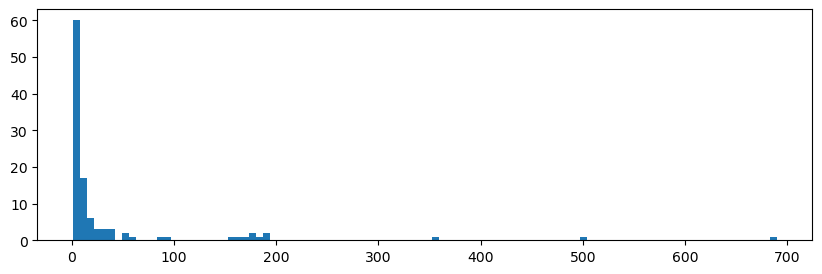

In [84]:
# 게시물별 댓글 분포
df = df_origin.copy()
tmp = df.groupby(['tag', 'href'])['title'].count().reset_index()
tmp[tmp['tag'] == '두피샴푸']['title'].hist(figsize = (10, 3), bins = 100, grid = False)

href_series = tmp[tmp['tag'] == '두피샴푸'].sort_values(by = 'title', ascending = False).iloc[:5]['href']
print(href_series)
print(tmp[tmp['tag'] == '두피샴푸'].agg({'title': ['mean', 'std']}))

6     https://daedamo.com/ingre/110?sca=탈모관련상품&overl...
95    https://daedamo.com/ingre/606?sca=탈모관련상품&overl...
82    https://daedamo.com/ingre/497?sca=탈모관련상품&overl...
69    https://daedamo.com/ingre/3540?sca=탈모관련상품&over...
42    https://daedamo.com/ingre/213?sca=탈모관련상품&overl...
Name: href, dtype: object
          title
mean  37.231481
std   96.110684


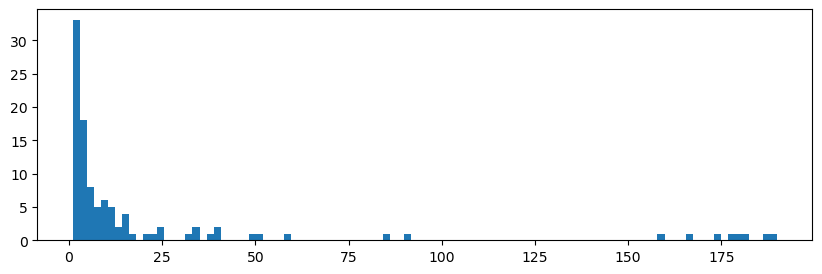

In [85]:
# 게시물별 댓글 분포
df = df_origin.copy()
tmp = df.groupby(['tag', 'href'])['title'].count().reset_index()
tmp = tmp[tmp['title'] <= 200]
tmp[tmp['tag'] == '두피샴푸']['title'].hist(figsize = (10, 3), bins = 100, grid = False)

tmp = df.groupby(['tag', 'href'])['title'].count().reset_index()
href_series = tmp[tmp['tag'] == '두피샴푸'].sort_values(by = 'title', ascending = False).iloc[:5]['href']
print(href_series)
print(tmp[tmp['tag'] == '두피샴푸'].agg({'title': ['mean', 'std']}))

232    https://daedamo.com/ingre/479?sca=탈모관련상품&overl...
234    https://daedamo.com/ingre/507?sca=탈모관련상품&overl...
134    https://daedamo.com/ingre/135?sca=탈모관련상품&overl...
224    https://daedamo.com/ingre/27320?sca=탈모관련상품&ove...
235    https://daedamo.com/ingre/508?sca=탈모관련상품&overl...
Name: href, dtype: object
           title
mean   69.155556
std   316.259172


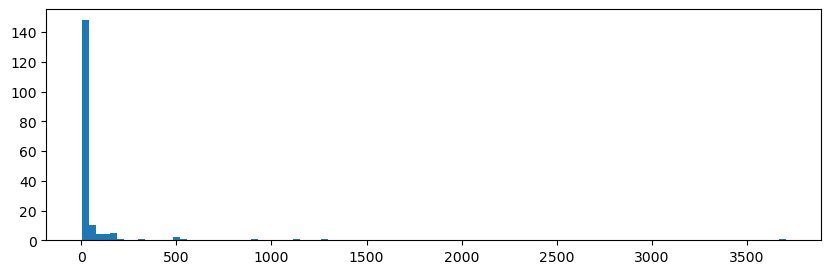

In [86]:
tmp = df.groupby(['tag', 'href'])['title'].count().reset_index()
tmp[tmp['tag'] == '탈모샴푸']['title'].hist(figsize = (10, 3), bins = 100, grid = False)

href_series = tmp[tmp['tag'] == '탈모샴푸'].sort_values(by = 'title', ascending = False).iloc[:5]['href']
print(href_series)
print(tmp[tmp['tag'] == '탈모샴푸'].agg({'title': ['mean', 'std']}))

232    https://daedamo.com/ingre/479?sca=탈모관련상품&overl...
234    https://daedamo.com/ingre/507?sca=탈모관련상품&overl...
134    https://daedamo.com/ingre/135?sca=탈모관련상품&overl...
224    https://daedamo.com/ingre/27320?sca=탈모관련상품&ove...
235    https://daedamo.com/ingre/508?sca=탈모관련상품&overl...
Name: href, dtype: object
           title
mean   69.155556
std   316.259172


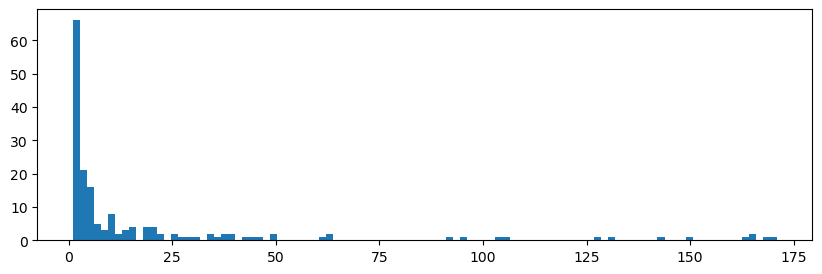

In [87]:
tmp = df.groupby(['tag', 'href'])['title'].count().reset_index()
tmp = tmp[tmp['title'] <= 200]
tmp[tmp['tag'] == '탈모샴푸']['title'].hist(figsize = (10, 3), bins = 100, grid = False)

tmp = df.groupby(['tag', 'href'])['title'].count().reset_index()
href_series = tmp[tmp['tag'] == '탈모샴푸'].sort_values(by = 'title', ascending = False).iloc[:5]['href']
print(href_series)
print(tmp[tmp['tag'] == '탈모샴푸'].agg({'title': ['mean', 'std']}))

<Axes: >

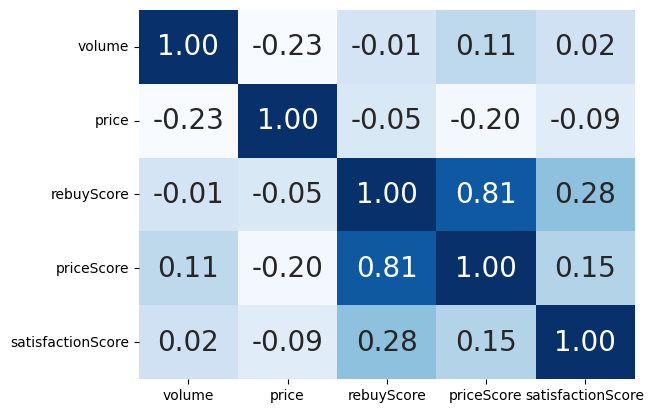

In [88]:
# 세부항목별 상관관계 그래프
df = df_origin.copy()
tmp = df[~condition00 & (df['tag'] == '두피샴푸')]
tmp = tmp[['volume', 'price', 'rebuyScore', 'priceScore', 'satisfactionScore']]
for column in tmp.columns:
    tmp[column] = tmp[column].astype(int)
corr = tmp.corr()
column_name = ['volume', 'price', 'rebuyScore', 'priceScore', 'satisfactionScore']

sns.heatmap(corr.values,
            cbar = False,
            annot = True,
            annot_kws = {'size' : 20},
            fmt = '.2f',
            yticklabels = column_name,
            xticklabels = column_name,
            cmap='Blues')

<Axes: >

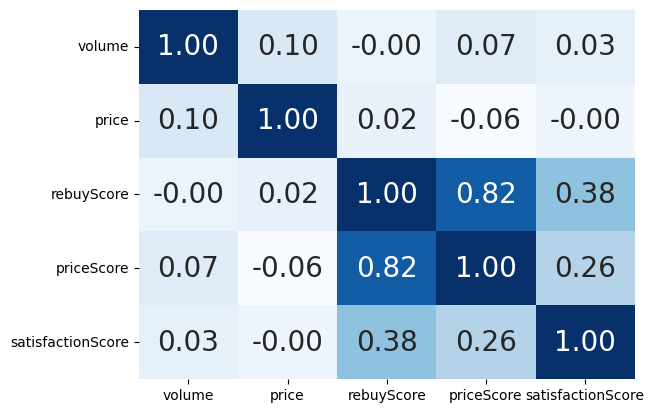

In [89]:
tmp = df[~condition00 & (df['tag'] == '탈모샴푸')]
tmp = tmp[['volume', 'price', 'rebuyScore', 'priceScore', 'satisfactionScore']]
for column in tmp.columns:
    tmp[column] = tmp[column].astype(int)
corr = tmp.corr()
column_name = ['volume', 'price', 'rebuyScore', 'priceScore', 'satisfactionScore']

sns.heatmap(corr.values,
            cbar = False,
            annot = True,
            annot_kws = {'size' : 20},
            fmt = '.2f',
            yticklabels = column_name,
            xticklabels = column_name,
            cmap='Blues')

          volume         price
mean  449.018519  29865.462963
std   233.042332  16585.326776


c:\Users\WESLEYQUEST\anaconda3\envs\BigDataUtilization2023\Lib\site-packages\seaborn\axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


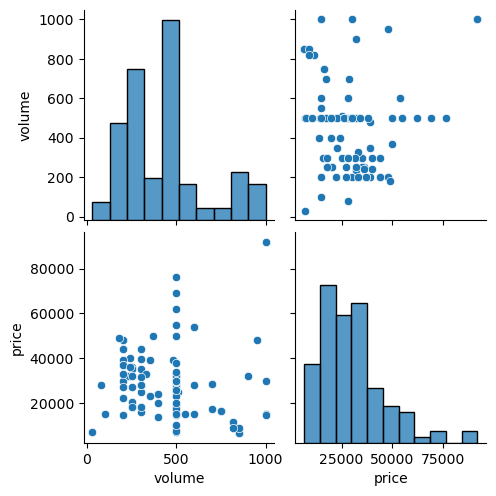

In [92]:
# 두피샴푸의 가격, 용량 pairPlot
df = df_origin.copy()
tmp = df.drop_duplicates(subset = ['href', 'tag', 'volume', 'price'])
tmp = tmp[tmp['tag'] == '두피샴푸']

print(tmp.agg({'volume' : ['mean', 'std'], 'price' : ['mean', 'std']}))

sns.pairplot(tmp[['volume', 'price']])

c:\Users\WESLEYQUEST\anaconda3\envs\BigDataUtilization2023\Lib\site-packages\seaborn\axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


          volume         price
mean  480.877778  33026.444444
std   196.363466  20179.673899


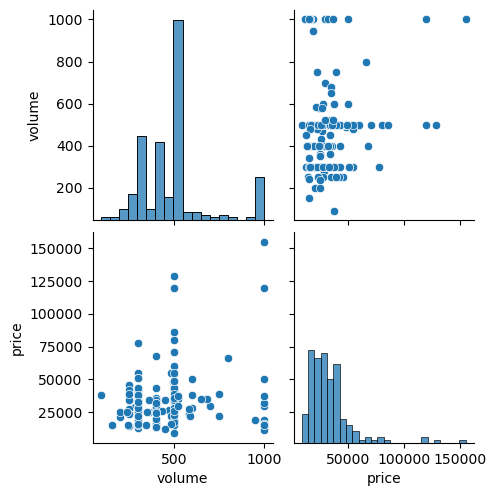

In [93]:
# 탈모샴푸의 가격, 용량 pairPlot
df = df_origin.copy()
tmp = df.drop_duplicates(subset = ['href', 'tag', 'volume', 'price'])
tmp = tmp[tmp['tag'] == '탈모샴푸']
sns.pairplot(tmp[['volume', 'price']])
print(tmp.agg({'volume' : ['mean', 'std'], 'price' : ['mean', 'std']}))